In [54]:
import os
import sgml, dproc, sgml, sgpp, sgutil, cupp
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
import warnings 
warnings.simplefilter('ignore', FutureWarning)

- clean_title은 yes 아니면 결측이다. fillna를 'no'로 하고 yes -> 1 no -> 0 으로 대치
- milage와 price_c는 반비례 관계에 있습니다. 역수를 취해볼만 합니다.

In [2]:
sc = sgutil.SGCache('img', 'result', 'model')
p = make_pipeline(
    sgpp.PolarsProcessor({'engine': pl.String, 'clean_title': pl.String, 'fuel_type': pl.String, 'accident': pl.String}),
    sgpp.ExprProcessor({
        'clean_title': pl.col('clean_title').fill_null('No') == 'Yes',
        'fuel_type': pl.col('fuel_type').fill_null('Unknown').cast(pl.Categorical),
        'accident': pl.col('accident').fill_null('Unknown').cast(pl.Categorical),
        'milage_r': 1 / pl.col('milage'),
    }),
    sgpp.PandasConverter(index_col = 'id'),
    sgpp.ApplyWrapper(cupp.PGS4EP9Processor(), ['engine']),
)

df_train = p.fit_transform(['data/train.csv'])
df_test = p.transform(['data/test.csv'])

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188533 entries, 0 to 188532
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   brand             188533 non-null  category
 1   model             188533 non-null  category
 2   model_year        188533 non-null  int16   
 3   milage            188533 non-null  int32   
 4   fuel_type         188533 non-null  category
 5   transmission      188533 non-null  category
 6   ext_col           188533 non-null  category
 7   int_col           188533 non-null  category
 8   accident          188533 non-null  category
 9   clean_title       188533 non-null  bool    
 10  price             188533 non-null  int32   
 11  milage_r          188533 non-null  float64 
 12  HP                155274 non-null  float16 
 13  displacement      174319 non-null  float16 
 14  engine_type       188533 non-null  object  
 15  fuel_type_engine  188533 non-null  object  
 16  engine 

In [4]:
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold, cross_validate, cross_val_score, ShuffleSplit, train_test_split
kf = KFold(5, shuffle = True, random_state = 123)
ss = ShuffleSplit(1, train_size = 0.6, random_state = 123)
target = 'price'
X_all = df_test.columns.tolist()
def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size = validation_fraction)

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict(df[X]), index = df.index).rename(target),
    'score_func': lambda df, prds: root_mean_squared_error(df[target], prds),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(), 
    'return_train_scores': True,
    'y': target,
}

lgb_adapter = sgml.LGBMAdapter(lgb.LGBMRegressor, progress = 50)
xgb_adapter = sgml.XGBAdapter(xgb.XGBRegressor, progress = 50)
cb_adapter = sgml.CBAdapter(cb.CatBoostRegressor, progress = 50)

In [36]:
hparams = {
    'model_params': {'n_estimators': 100}, 
    'X_num' : ['model_year', 'milage', 'clean_title', 'HP', 'displacement'],
    'X_cat' : ['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'accident', 'engine_type', 'fuel_type_engine', 'engine'],
    'cat': {'handle_unknown': 'use_encoded_value', 'unknown_value': -1, 'encoded_missing_value': -1}
}
result_lgb = sc.cache_result(
    'lgb_pilot', lambda : sgml.cv(df_train, ss, hparams, config, lgb_adapter), rerun = 1
)
result_lgb['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/100 [00:00<?, ?it/s]

/home/sun9sun9/python312/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/sun9sun9/python312/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[72907.88775089185]

In [37]:
result_lgb['model_result'][0]['feature_importance'].sort_values(ascending = False)

pt__milage               763
pt__model_year           429
cat__model               398
cat__engine              287
cat__ext_col             206
pt__displacement         192
pt__HP                   189
cat__transmission        174
cat__int_col             152
pt__clean_title           69
cat__brand                50
cat__accident             43
cat__fuel_type_engine     35
cat__engine_type          13
cat__fuel_type             0
dtype: int32

In [38]:
hparams = {
    'model_params': {'enable_categorical': True, 'n_estimators': 100}, 
    'X_num' : ['model_year', 'milage', 'clean_title', 'HP', 'displacement'],
    'X_cat' : ['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'accident', 'engine_type', 'fuel_type_engine', 'engine'],
    'cat': {'handle_unknown': 'use_encoded_value', 'unknown_value': -1, 'encoded_missing_value': -1}
}
result_xgb = sc.cache_result(
    'xgb_pilot', lambda : sgml.cv(df_train, ss, hparams, config, xgb_adapter), rerun = 0
)
result_xgb['valid_scores']

[77398.2578125]

In [39]:
result_xgb['model_result'][0]['feature_importance'].sort_values(ascending = False)

pt__HP                   0.178984
pt__milage               0.126011
cat__fuel_type_engine    0.097950
pt__clean_title          0.094235
cat__accident            0.089098
pt__model_year           0.060070
cat__int_col             0.056046
cat__model               0.053402
cat__engine_type         0.048425
cat__engine              0.047955
cat__ext_col             0.043668
cat__transmission        0.042059
cat__brand               0.032475
cat__fuel_type           0.029622
pt__displacement         0.000000
dtype: float32

In [41]:
hparams = {
    'model_params': {'n_estimators': 200}, 
    'X_num' : ['model_year', 'milage', 'clean_title', 'HP', 'displacement'],
    'X_cat' : ['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'accident', 'engine_type', 'fuel_type_engine', 'engine'],
    'cat': {'handle_unknown': 'use_encoded_value', 'unknown_value': -1, 'encoded_missing_value': -1}
}
result_cb = sc.cache_result(
    'cb_pilot', lambda : sgml.cv(
        df_train, ss, hparams, config, cb_adapter, 
        result_proc = [sgml.cb_interaction_importance, sgml.cb_learning_result]
    ), rerun = 0
)
result_cb['valid_scores']

[71565.70831067943]

In [78]:
result_cb['model_result'][0].iloc[:15]

,Var1,Var2,Importance
0,pt__model_year,pt__milage,5.629805
1,cat__brand,pt__milage,2.720819
2,cat__brand,pt__model_year,2.511667
3,cat__ext_col,cat__int_col,2.089520
4,cat__int_col,cat__fuel_type_engine,2.062058
5,cat__int_col,cat__engine_type,1.992691
6,cat__transmission,cat__ext_col,1.947329
7,cat__transmission,cat__int_col,1.939537
8,cat__transmission,cat__engine_type,1.915782
9,cat__ext_col,pt__model_year,1.880069


In [79]:
result_cb['model_result'][1]['feature_importance'].sort_values(ascending = False)

pt__milage               26.048800
pt__model_year           10.276279
cat__brand                9.311901
cat__engine_type          8.257246
pt__displacement          7.785846
pt__HP                    7.293912
cat__ext_col              5.922364
cat__int_col              5.752403
cat__fuel_type_engine     5.720699
cat__transmission         4.080690
cat__model                2.636245
cat__engine               2.411754
cat__fuel_type            2.081575
cat__accident             1.641072
pt__clean_title           0.779214
dtype: float64

- 과적합이 쉽게 일어납니다.

In [62]:
prds = pd.concat([
    result_lgb['valid_prd'].rename('lgb'), 
    result_xgb['valid_prd'].rename('xgb'), 
    result_cb['valid_prd'].rename('cb')
], axis=1).mean(axis = 1)
df_prd = df_train.loc[prds.index].assign(
    resi = lambda x: x[target] - prds,
    resi2 = lambda x: x['resi'] ** 2
)
root_mean_squared_error(df_prd[target], prds)

72191.5513935219

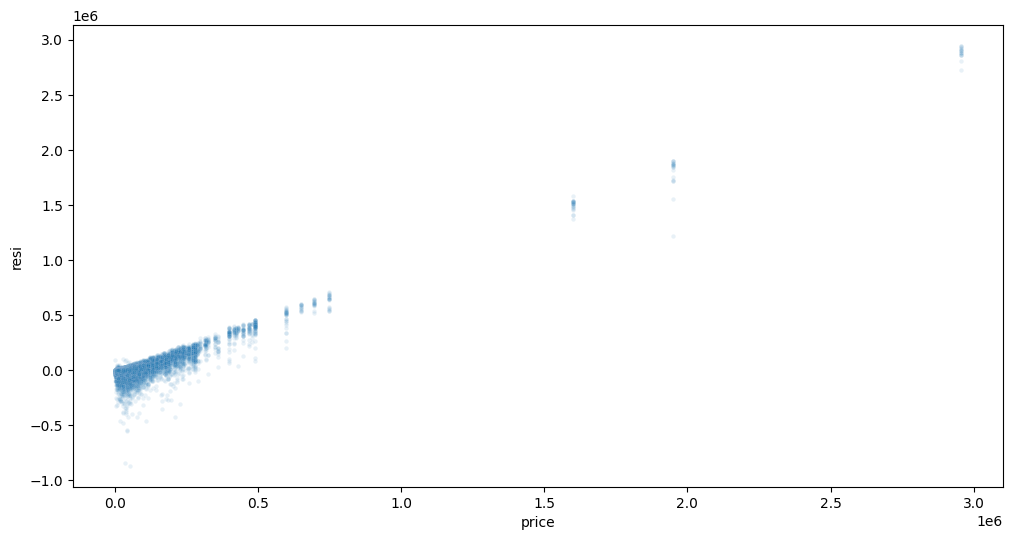

In [50]:
plt.figure(figsize = (12, 6))
sns.scatterplot(df_prd, x = target, y = 'resi', s = 10, alpha = 0.1)
plt.show()

In [119]:
df_prd.query('price < 1.5e6').pipe(
    lambda x: x['resi2'].mean() ** 0.5
)

42069.659137453586

In [120]:
df_prd.query('price < 2.0e6').pipe(
    lambda x: x['resi2'].mean() ** 0.5
)

57776.28211900832

- brand와 model의 일관되지 않는 점이 오차에 미치는 영향을 조사해봅니다.

In [63]:
df_prd.groupby(
    df_prd.groupby('model', group_keys = False, observed = True)['brand'].apply(lambda x: x == x.mode()[0])
)['resi2'].mean()

brand
False    2.690785e+09
True     5.238477e+09
Name: resi2, dtype: float64

In [64]:
df_prd.groupby('model', group_keys = False, observed = True)['brand'].apply(lambda x: x == x.mode()[0]).value_counts()

brand
True     74619
False      795
Name: count, dtype: int64

In [76]:
df_prd.groupby('brand')['resi2'].agg(['mean', 'size']).sort_values('mean', ascending = False).iloc[:30]

,mean,size
brand,,
Aston,8.075302e+10,113
Lamborghini,4.580111e+10,316
Pontiac,4.291383e+10,202
Rolls-Royce,3.509400e+10,216
Bentley,3.338736e+10,471
Ferrari,2.628927e+10,150
Bugatti,1.891830e+10,4
RAM,1.174134e+10,1701
Hyundai,1.143855e+10,789


In [83]:
df_prd.groupby('fuel_type')['resi2'].agg(['mean', 'size']).sort_values('mean', ascending = False)

,mean,size
fuel_type,,
–,8.458348e+09,333
Gasoline,5.443356e+09,66386
Diesel,4.381960e+09,1547
Hybrid,4.145802e+09,2765
E85 Flex Fuel,2.736388e+09,2187
Unknown,2.135505e+09,1995
Plug-In Hybrid,1.847336e+09,196
not supported,1.838695e+08,5


In [85]:
df_prd.groupby('model_year')['resi2'].agg(['mean', 'size']).sort_values('mean', ascending = False)

,mean,size
model_year,,
1995,5.208810e+10,44
2001,2.993072e+10,593
2005,1.590050e+10,1281
2002,1.496173e+10,514
2022,1.154516e+10,6274
2023,1.132304e+10,3530
2010,9.870660e+09,1677
2020,6.537031e+09,6330
1994,6.003785e+09,37


In [99]:
df_prd.groupby('fuel_type_engine')['resi2'].agg(['mean', 'size']).sort_values('mean', ascending = False).iloc[:30]

,mean,size
fuel_type_engine,,
48V MPFI DOHC,1.314608e+11,38
32V PDI DOHC,1.033369e+11,86
16V PDI DOHC,9.415308e+10,90
40V GDI DOHC,9.215431e+10,72
16V MPFI OHV Flexible Fuel,8.928281e+10,9
48V PDI DOHC Twin Turbo,6.780467e+10,59
48V GDI DOHC Twin Turbo,5.427153e+10,97
16V MPFI OHV,2.751623e+10,699
32V GDI DOHC Twin Turbo,2.732861e+10,779


In [100]:
df_prd.groupby('int_col')['resi2'].agg(['mean', 'size']).sort_values('mean', ascending = False).iloc[:30]

,mean,size
int_col,,
Shale,3.932093e+11,9
Black / Brown,2.187741e+11,14
Sandstone,1.807428e+11,49
Hotspur,1.713227e+11,16
Yellow,1.314582e+11,19
Diesel Gray / Black,8.999959e+10,97
Nero Ade,7.129044e+10,136
Magma Red,5.654378e+10,9
Orchid,5.029160e+10,6


In [101]:
df_prd.groupby('ext_col')['resi2'].agg(['mean', 'size']).sort_values('mean', ascending = False).iloc[:30]

,mean,size
ext_col,,
Blue Caelum,5.284657e+11,4
C / C,4.575728e+11,12
Bianco Monocerus,4.143836e+11,5
Beluga Black,3.266181e+11,28
China Blue,2.470448e+11,15
Nero Noctis,1.677179e+11,21
Bianco Icarus Metallic,9.243385e+10,27
Donington Grey Metallic,6.214430e+10,16
Silver Ice Metallic,5.040127e+10,182


In [102]:
df_prd.groupby('transmission')['resi2'].agg(['mean', 'size']).sort_values('mean', ascending = False).iloc[:30]

,mean,size
transmission,,
4-Speed Automatic,1.983820e+11,18
–,7.086085e+10,42
7-Speed DCT Automatic,6.912615e+10,7
7-Speed Automatic with Auto-Shift,3.764961e+10,492
5-Speed Automatic,3.522350e+10,64
8-Speed Automatic with Auto-Shift,3.259105e+10,218
8-Speed Automatic,1.944943e+10,3363
Manual,1.853468e+10,9
7-Speed,1.745032e+10,12


In [103]:
df_prd.groupby('accident')['resi2'].agg(['mean', 'size']).sort_values('mean', ascending = False).iloc[:30]

,mean,size
accident,,
Unknown,8.116538e+09,985
None reported,5.981716e+09,57783
At least 1 accident or damage reported,2.366505e+09,16646


In [104]:
df_prd.groupby('clean_title')['resi2'].agg(['mean', 'size']).sort_values('mean', ascending = False).iloc[:30]

,mean,size
clean_title,,
False,8.066522e+09,8597
True,4.844295e+09,66817


In [105]:
df_prd.groupby('engine_type')['resi2'].agg(['mean', 'size']).sort_values('mean', ascending = False).iloc[:30]

,mean,size
engine_type,,
V12,6.957849e+10,155
12 Cylinder Engine,6.072065e+10,520
V10,5.010384e+10,146
V8,2.323573e+10,2787
10 Cylinder Engine,2.315861e+10,271
I4,9.040434e+09,2352
Unknown,6.625872e+09,4247
6 Cylinder Engine,6.088648e+09,6828
8 Cylinder Engine,4.475176e+09,21020


- int_col과 ext_col의 일치 여부의 영향도

In [107]:
df_prd.groupby(
    df_prd['int_col'].astype('str') == df_prd['ext_col'].astype('str')
)['resi2'].mean()

False    5.022628e+09
True     5.886741e+09
Name: resi2, dtype: float64

In [108]:
df_train.groupby(
    df_train['int_col'].astype('str') == df_train['ext_col'].astype('str')
)[target].mean()

False    43865.081834
True     43924.307330
Name: price, dtype: float64

In [114]:
().describe()

count    188533.000000
mean          9.170002
std           5.660967
min           1.000000
25%           5.000000
50%           8.000000
75%          12.000000
max          51.000000
Name: model_year, dtype: float64

- 모델 연식 대비 milage를 봅니다.

In [117]:
from scipy.stats import pearsonr
pearsonr(
    df_train[target], df_train['milage'] / (2025 - df_train['model_year'])
)

PearsonRResult(statistic=-0.15770985785742492, pvalue=0.0)

- price가 2.5e5이 넘는 것을 예측모델을 만들어봅니다.

In [126]:
(df_train['price'] > 2.5e5).mean()

0.01071430465754006

In [127]:
df_train['high_price'] = df_train['price'] > 2.5e5

In [136]:
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, cross_validate, cross_val_score, ShuffleSplit, train_test_split

config2 = {
    'predict_func': lambda m, df, X: pd.Series(m.predict_proba(df[X])[:, 1], index = df.index).rename(target),
    'score_func': lambda df, prds: roc_auc_score(df['high_price'], prds),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(), 
    'return_train_scores': True,
    'y': 'high_price',
}

cb_adapter2 = sgml.CBAdapter(cb.CatBoostClassifier, progress = 50)

In [137]:
hparams = {
    'model_params': {'n_estimators': 200}, 
    'X_num' : ['model_year', 'milage', 'clean_title', 'HP', 'displacement'],
    'X_cat' : ['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'accident', 'engine_type', 'fuel_type_engine', 'engine'],
    'cat': {'handle_unknown': 'use_encoded_value', 'unknown_value': -1, 'encoded_missing_value': -1}
}
result_cb = sc.cache_result(
    'cb_pilot2', lambda : sgml.cv(
        df_train, ss, hparams, config2, cb_adapter2, 
        result_proc = [sgml.cb_interaction_importance, sgml.cb_learning_result]
    ), rerun = 0
)
result_cb['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/200 [00:00<?, ?it/s]

[0.8738508213329861]

In [139]:
result_cb['model_result'][0].iloc[:15]

,Var1,Var2,Importance
0,cat__brand,cat__ext_col,3.114242
1,cat__transmission,cat__int_col,3.040248
2,cat__brand,cat__transmission,2.753670
3,cat__ext_col,cat__int_col,2.648541
4,cat__transmission,cat__fuel_type_engine,2.629742
5,cat__brand,cat__int_col,2.416118
6,cat__brand,cat__model,2.344190
7,cat__brand,pt__milage,2.275067
8,cat__model,cat__transmission,2.190180
9,cat__ext_col,pt__milage,2.112373


In [140]:
result_cb['model_result'][1]['feature_importance'].sort_values(ascending = False)

pt__milage               53.338131
pt__displacement          5.967314
cat__brand                5.101581
cat__transmission         5.033987
pt__model_year            4.829987
cat__model                4.516867
pt__HP                    3.508459
cat__engine_type          3.406274
cat__int_col              2.875731
cat__ext_col              2.852826
cat__fuel_type_engine     2.523294
cat__engine               2.416162
cat__accident             1.874477
cat__fuel_type            1.016330
pt__clean_title           0.738581
dtype: float64

In [141]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188533 entries, 0 to 188532
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   brand             188533 non-null  category
 1   model             188533 non-null  category
 2   model_year        188533 non-null  int16   
 3   milage            188533 non-null  int32   
 4   fuel_type         188533 non-null  category
 5   transmission      188533 non-null  category
 6   ext_col           188533 non-null  category
 7   int_col           188533 non-null  category
 8   accident          188533 non-null  category
 9   clean_title       188533 non-null  bool    
 10  price             188533 non-null  int32   
 11  milage_r          188533 non-null  float64 
 12  HP                155274 non-null  float16 
 13  displacement      174319 non-null  float16 
 14  engine_type       188533 non-null  object  
 15  fuel_type_engine  188533 non-null  object  
 16  engine 

In [144]:
from scipy.stats import chi2_contingency
from scipy.spatial.distance import pdist
X_cat = "brand, model, fuel_type, transmission, ext_col, int_col, accident, clean_title, engine_type, fuel_type_engine"
X_cat = X_cat.split(', ')
pdist(df_train[X_cat].T, lambda u, v: chi2_contingency(pd.crosstab(index = u, columns = v))[1])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

- 속성의 공선성이 강한 데이터입니다.

In [177]:
v_cnt = df_train[X_cat].value_counts()
v_cnt

brand          model                 fuel_type  transmission  ext_col  int_col  accident                                clean_title  engine_type        fuel_type_engine
Ford           Mustang GT Premium    Gasoline   6-Speed M/T   Black    Black    None reported                           True         8 Cylinder Engine  Gasoline Fuel       242
                                                              White    Black    None reported                           True         8 Cylinder Engine  Gasoline Fuel       176
Mercedes-Benz  G-Class G 550 4MATIC  Gasoline   A/T           Black    Black    None reported                           True         8 Cylinder Engine  Gasoline Fuel       174
Ford           F-150 Lariat          Gasoline   10-Speed A/T  Gray     Black    None reported                           True          V6                Gasoline Fuel       161
               F-150 XLT             Gasoline   10-Speed A/T  Gray     Gray     None reported                           True   

In [179]:
df_general = df_train.groupby(X_cat).filter(lambda x: len(x) == v_cnt[0])

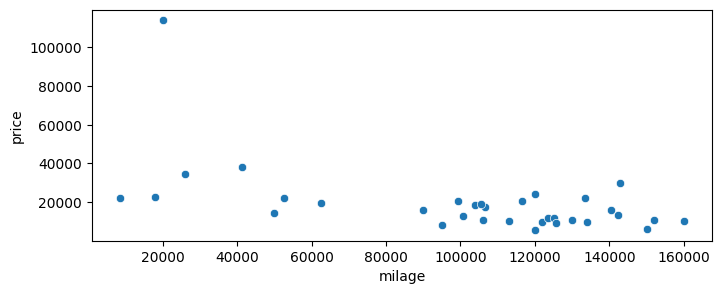

In [154]:
plt.figure(figsize = (8, 3))
df_general.loc[df_general['model_year'] == 2011].pipe(
    lambda x: sns.scatterplot(x, x = 'milage', y = target)
)
plt.show()

- 동일한 model_year와 동일한 범주형들의 최빈 데이터에서 이상치로 보이는 데이터 포인트가 있습니다

In [164]:
from sklearn.linear_model import LinearRegression

In [167]:
df_general.loc[df_general['model_year'] == 2011,].pipe(
    lambda x: ((x[target] - LinearRegression().fit(x[['milage']], x[target]).predict(x[['milage']])) ** 2).mean() ** 0.5
)

15572.619202606185

In [168]:
df_general.loc[df_general['model_year'] == 2011,].sort_values(target).pipe(
    lambda x: ((x[target] - LinearRegression().fit(x.iloc[:-1][['milage']], x.iloc[:-1][target]).predict(x[['milage']])) ** 2).mean() ** 0.5
)

16637.590973112492

제외한 것보다는 제외하지 않은 것이, RMSE는 낮습니다.

In [171]:
df_general[target].std()

18281.105605684737

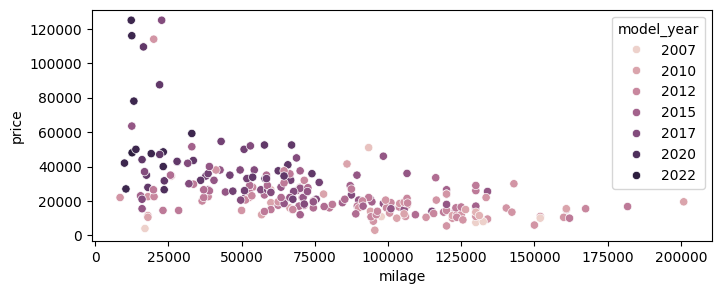

In [173]:
plt.figure(figsize = (8, 3))
sns.scatterplot(df_general, x = 'milage', y = target, hue = 'model_year')
plt.show()

In [180]:
X_cat2 = [i for i in X_cat if i != 'ext_col']
v_cnt = df_train[X_cat2].value_counts()
df_general = df_train.groupby(X_cat2).filter(lambda x: len(x) == v_cnt[0])

In [187]:
df_general.loc[df_general['ext_col'].isin(df_general['ext_col'].value_counts()[:3].index), 'ext_col'].value_counts()

ext_col
Black                                      242
White                                      176
Silver                                      74
Yellow                                       0
Shoreline Blue Pearl                         0
                                          ... 
Daytona Gray Pearl Effect w/ Black Roof      0
Jet Black Mica                               0
Brilliant Black                              0
Alta White                                   0
GT SILVER                                    0
Name: count, Length: 319, dtype: int64

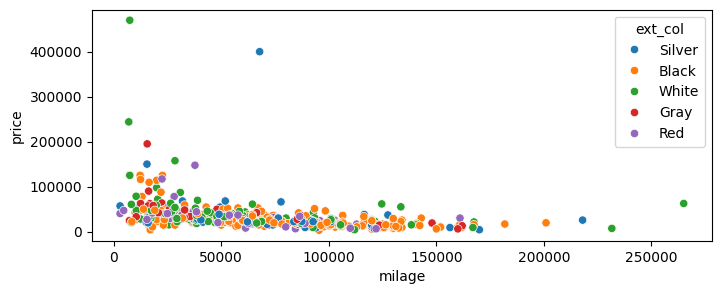

In [191]:
plt.figure(figsize = (8, 3))
sns.scatterplot(
    df_general.loc[df_general['ext_col'].isin(df_general['ext_col'].value_counts()[:5].index)].assign(
        ext_col = lambda x: x['ext_col'].cat.remove_unused_categories()
    ), 
    x = 'milage', y = target, hue = 'ext_col'
)
plt.show()

In [198]:
from scipy.stats import f_oneway

f_oneway(
    *df_general.groupby('ext_col').filter(lambda x: len(x) > 10).groupby('ext_col', observed = True)[target].agg(list)
)

F_onewayResult(statistic=3.0547390203023164, pvalue=0.009806253429124149)

In [199]:
X_cat2 = [i for i in X_cat if i != 'int_col']
v_cnt = df_train[X_cat2].value_counts()
df_general = df_train.groupby(X_cat2).filter(lambda x: len(x) == v_cnt[0])

In [200]:
from scipy.stats import f_oneway

f_oneway(
    *df_general.groupby('int_col').filter(lambda x: len(x) > 10).groupby('int_col', observed = True)[target].agg(list)
)

F_onewayResult(statistic=0.9906312118511602, pvalue=0.3203956343006247)

In [ ]:
- brand와 model이 일관되지 않은 케이스를 봅니다.

In [207]:
df_train.loc[
    df_train.groupby('model', group_keys = False)['brand'].apply(lambda x: x != x.mode()[0])
]

,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,milage_r,HP,displacement,engine_type,fuel_type_engine,engine,high_price
id,,,,,,,,,,,,,,,,,,
192,Ford,GT-R Premium,2009,51400,Gasoline,Transmission w/Dual Shift Mode,Orange,Black,None reported,True,13500,0.000019,480.0,3.800781,V6,Gasoline Fuel,480.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,False
251,Ferrari,911 GT2 RS,2022,19250,Gasoline,8-Speed A/T,Orange,Red,None reported,True,124900,0.000052,710.0,4.000000,8 Cylinder Engine,Gasoline Fuel,710.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,False
357,Toyota,Grand Cherokee L Laredo,2022,14676,Gasoline,Automatic,Bright White Clearcoat,Black,None reported,True,53722,0.000068,NaN,3.599609,V6,24V MPFI DOHC,3.6L V6 24V MPFI DOHC,False
389,BMW,Equus Signature,2013,82000,Gasoline,8-Speed A/T,Red,Beige,None reported,True,17900,0.000012,429.0,5.000000,8 Cylinder Engine,Gasoline Fuel,429.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,False
430,Porsche,Bronco Wildtrak Advanced,2022,10900,Gasoline,Transmission w/Dual Shift Mode,Black,Black,None reported,True,65700,0.000092,315.0,2.699219,V6,Gasoline Fuel,315.0HP 2.7L V6 Cylinder Engine Gasoline Fuel,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187815,Porsche,488 Spider Base,2017,57550,Gasoline,Transmission w/Dual Shift Mode,White,Orange,At least 1 accident or damage reported,True,19990,0.000017,660.0,3.900391,8 Cylinder Engine,Gasoline Fuel,660.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,False
188027,Nissan,Mustang V6 Premium,2011,172600,Gasoline,5-Speed A/T,Blue,Beige,At least 1 accident or damage reported,True,20995,0.000006,305.0,3.699219,V6,Gasoline Fuel,305.0HP 3.7L V6 Cylinder Engine Gasoline Fuel,False
188139,Tesla,Leaf SL,2011,56450,Unknown,1-Speed A/T,Red,White,At least 1 accident or damage reported,True,9100,0.000018,107.0,NaN,Electric Motor,Electric Fuel System,107.0HP Electric Motor Electric Fuel System,False


In [211]:
df_train.loc[
    df_train['model'] == 'GT-R Premium', 'brand'
].value_counts().pipe(lambda x: x.loc[x > 0])

brand
Nissan           286
Ford               3
BMW                2
Porsche            2
Mercedes-Benz      1
Ferrari            1
Name: count, dtype: int64

In [212]:
df_train.loc[
    df_train['model'] == 'GT-R Premium'
].groupby('brand', observed = True)[target].mean()

brand
Mercedes-Benz     77500.000000
Ford              26000.000000
BMW              103000.000000
Porsche           34500.000000
Nissan            74002.660839
Ferrari           18500.000000
Name: price, dtype: float64